# Running analysis for scIHPF 

In [3]:
## Import scripts for the dimension reduction methods 
import IHPF
import INMF 
import schpf
from sklearn.decomposition import PCA

In [32]:
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData

In [33]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

In [34]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

AnnData object with n_obs × n_vars = 9530 × 13130
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'PCA_kmeans_normalised', 'IHPF_max', 'INMF_max', 'HPF_max', 'PCA_max', 'INMF_0.1_kmeans_normalised', 'INMF_0.1_max', 'INMF_0.5_kmeans_normalised', 'INMF_0.5_max', 'INMF_1.0_kmeans_normalised', 'INMF_1.0_max', 'INMF_10.0_kmeans_normalised', 'INMF_10.0_max', 'INMF_1e-05_kmeans_normalised', 'INMF_1e-05_max', 'INMF_0.0001_kmeans_normalised', 'INMF_0.0001_max', 'INMF_0.001_kmeans_normalised', 'INMF_0.001_max', 'INMF_0.01_kmeans_normalised', 'INMF_0.01_max', 'IHPF_0.1_kmeans_normalised', 'IHPF_0.1_max', 'IHPF_0.5_kmeans_normalised', 'IHPF_0.5_max', 'IHPF_1.0_kmeans_normalised', 'IHPF_1.0_max', 'IHPF_10.0_kmeans_normalised', 'IHPF_10.0_max', 'IHPF_1e-05_kmeans_normalised', 'IHPF_1e-05_max', 'IHPF_0.0001_kmeans_normalised', 'IHPF_0.0001_max', 'IHPF_0.001_kmeans_normalised', 'IHPF_0.001_max', 'IHPF_0.01_kmeans_normalised', 'IHPF_0.01_max'
   

## IHPF 

In [109]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual' 
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = IHPF.scIHPF(no_cell_types,max_iter=500)
    model.fit(Xlist,dataset_ratio=0.1)
    adata.obsm['IHPF'] = np.concatenate(model.cell_scores(),axis=0)
    adata.varm['IHPF'] = model.shared_gene_scores()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['IHPF']))
    adata.obs['IHPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['IHPF_max'] = np.argmax(adata.obsm['IHPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))
    

/home/mw4315/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Clipping dp: was [0.00010688119800761342, 9.911463712342083e-05, 6.813005165895447e-05, 7.410242687910795e-05] now [7.607926428318023e-05, 7.020594179630279e-05, 5.657629296183586e-05, 7.423592358827591e-05]
[Iter.    0]  loss:7.015150  pct:100.000000000
[Iter.   10]  loss:6.014359  pct:-14.266135762
[Iter.   20]  loss:5.975136  pct:-0.652166959
[Iter.   30]  loss:5.957813  pct:-0.289911179
[Iter.   40]  loss:5.899919  pct:-0.971725349
[Iter.   50]  loss:5.889629  pct:-0.174410088
[Iter.   60]  loss:5.888125  pct:-0.025545173
[Iter.   70]  loss:5.886807  pct:-0.022378490
[Iter.   80]  loss:5.886081  pct:-0.012336906
[Iter.   90]  loss:5.885622  pct:-0.007798312
[Iter.  100]  loss:5.885470  pct:-0.002579222
[Iter.  110]  loss:5.885316  pct:-0.002619635
[Iter.  120]  loss:5.885251  pct:-0.001110393
[Iter.  130]  loss:5.885079  pct:-0.002917359
[Iter.  140]  loss:5.884966  pct:-0.001925177
[Iter.  150]  loss:5.884913  pct:-0.000891301
[Iter.  160]  loss:5.884802  pct:-0.001884975
[Iter.  

## INMF 

In [110]:
from INMF import INMF

In [111]:
class scINMF:
    def __init__(self, k, alpha=1, **kwargs):
        np.random.seed(0)
        self.n_components = k
        self.method = INMF(
            n_components=self.n_components, solver="mu", alpha=alpha, **kwargs
        )

    def fit(self, X):
        self.data = X
        (
            self.cell_scores,
            self.shared_gene_scores,
            self.dataset_gene_scores,
        ) = self.method.fit_transform(self.data)


In [112]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual' 
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scINMF(no_cell_types,alpha=1,max_iter=500)
    model.fit(Xlist)
    adata.obsm['INMF'] = np.concatenate(model.cell_scores,axis=0)
    adata.varm['INMF'] = model.shared_gene_scores.transpose()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['INMF']))
    adata.obs['INMF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['INMF_max'] = np.argmax(adata.obsm['INMF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

Reconstruction error 12819.471509341638


## HPF

In [113]:
from schpf import scHPF
from scipy.sparse import vstack

In [114]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scHPF(no_cell_types,max_iter=500)
    model.fit(vstack(Xlist))
    adata.obsm['HPF'] = model.cell_score()
    adata.varm['HPF'] = model.gene_score()
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['HPF']))
    adata.obs['HPF_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['HPF_max'] = np.argmax(adata.obsm['HPF'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

[Iter.    0]  loss:2.193412  pct:100.000000000
[Iter.   10]  loss:1.437027  pct:-34.484374480
[Iter.   20]  loss:1.433848  pct:-0.221283887
[Iter.   30]  loss:1.385392  pct:-3.379415083
[Iter.   40]  loss:1.385582  pct:0.013691085
[Iter.   50]  loss:1.385284  pct:-0.021495691
[Iter.   60]  loss:1.385009  pct:-0.019867745
[Iter.   70]  loss:1.384702  pct:-0.022142281
[Iter.   80]  loss:1.384409  pct:-0.021151562
[Iter.   90]  loss:1.384149  pct:-0.018771484
[Iter.  100]  loss:1.383955  pct:-0.014048516
[Iter.  110]  loss:1.383783  pct:-0.012415549
[Iter.  120]  loss:1.383644  pct:-0.010013073
[Iter.  130]  loss:1.383550  pct:-0.006845956
[Iter.  140]  loss:1.383447  pct:-0.007376183
[Iter.  150]  loss:1.383365  pct:-0.005942993
[Iter.  160]  loss:1.383288  pct:-0.005580974
[Iter.  170]  loss:1.383240  pct:-0.003439573
[Iter.  180]  loss:1.383180  pct:-0.004403081
[Iter.  190]  loss:1.383123  pct:-0.004109920
[Iter.  200]  loss:1.383032  pct:-0.006568495
[Iter.  210]  loss:1.382994  pct:

## PCA

In [115]:
class scPCA:
    def __init__(self, k):
        from sklearn.decomposition import TruncatedSVD

        np.random.seed(0)
        self.n_components = k
        self.method = TruncatedSVD(n_components=self.n_components)

    def fit(self, X):
        self.data = X
        self.method.fit(self.data)
        self.cell_score = self.method.transform(self.data)
        self.gene_score = self.method.components_.transpose()

In [116]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    no_cell_types = len(adata.obs[cell_labels].unique())
    no_batches = len(adata.obs[batch_labels].unique())
    # Split cell matrix into batches preserving order 
    Xlist = list()
    split_idx = list()
    for i,df in adata.obs.groupby(batch_labels):
        df_ints = [int(x) for x in df.index]
        split_idx.append(min(df_ints))
    split_idx.append(adata.obs.shape[0])
    split_idx = sorted(split_idx)
    split_starts = split_idx[:-1]
    split_ends = split_idx[1:]
    for i in range(0,no_batches):
        Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
    model = scPCA(no_cell_types)
    model.fit(vstack(Xlist))
    adata.obsm['PCA'] = model.cell_score
    adata.varm['PCA'] = model.gene_score
    kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['PCA']))
    adata.obs['PCA_kmeans_normalised'] = kmeans_cell.labels_
    adata.obs['PCA_max'] = np.argmax(adata.obsm['PCA'],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

In [106]:
for dataset in datasets:
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

AnnData object with n_obs × n_vars = 9530 × 13130
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'PCA_kmeans_normalised', 'IHPF_max', 'INMF_max', 'HPF_max', 'PCA_max'
    obsm: 'HPF', 'IHPF', 'INMF', 'PCA'
    varm: 'HPF', 'IHPF', 'INMF', 'PCA'
AnnData object with n_obs × n_vars = 15921 × 5057
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'PCA_kmeans_normalised', 'IHPF_max', 'INMF_max', 'HPF_max', 'PCA_max'
    obsm: 'HPF', 'IHPF', 'INMF', 'PCA'
    varm: 'HPF', 'IHPF', 'INMF', 'PCA'
AnnData object with n_obs × n_vars = 26202 × 8234
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'PCA_kmeans_normalised', 'IHPF_max', 'INMF_max', 'HPF_max', 'PCA_max'
    obsm: 'HPF', 'IHPF', 'INMF', 'PCA'
    varm: 'HPF', 'IHPF', 'INMF', 'PCA'
AnnData object with n_obs × n_vars = 62114 × 6619
    obs: 'index', 'condition', 'species',

## Clustering performance

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score
from sklearn import preprocessing

In [43]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc',]

In [38]:
batchAMI = dict()
actualAMI = dict()

for dataset in datasets:
    if dataset == 'species':
        batch_labels = 'species'
        cell_labels = 'condition'
    else:
        batch_labels = 'batch'
        cell_labels = 'actual' 
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        batch[method] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs['{}_kmeans_normalised'.format(method)])
        actual[method] = adjusted_mutual_info_score(adata.obs[cell_labels],adata.obs['{}_kmeans_normalised'.format(method)])
    batch['actual'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    actual['batch'] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs[cell_labels])
    batchAMI[dataset] = batch
    actualAMI[dataset] = actual

In [39]:
np.round(pd.DataFrame(actualAMI),3)

,10Xmouse,humanpancreas,10Xpbmc
IHPF,0.976,0.276,0.590
INMF,0.200,0.188,0.043
HPF,-0.000,0.133,0.776
PCA,0.448,0.211,0.875
batch,0.498,0.032,0.842


In [40]:
np.round(pd.DataFrame(batchAMI),3)

,10Xmouse,humanpancreas,10Xpbmc
IHPF,0.498,0.113,0.757
INMF,0.294,0.257,0.065
HPF,0.745,0.818,0.949
PCA,0.739,0.494,0.935
actual,0.498,0.032,0.842


In [44]:
batchputriy = dict()
actualputriy = dict()

for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual' 
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        le = preprocessing.LabelEncoder()
        batchlabel = le.fit_transform(adata.obs[batch_labels])
        le = preprocessing.LabelEncoder()
        actuallabel = le.fit_transform(adata.obs[cell_labels])
        no_cell_types = len(adata.obs[cell_labels].unique())
        batch[method] = np.sum(np.max(confusion_matrix(batchlabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
        actual[method] = np.sum(np.max(confusion_matrix(actuallabel,adata.obs['{}_kmeans_normalised'.format(method)]),axis=1)) / len(adata.obs[cell_labels])
    actual['batch'] =  np.sum(np.max(confusion_matrix(actuallabel,batchlabel),axis=1)) / len(adata.obs[cell_labels])
    batchputriy[dataset] = batch
    actualputriy[dataset] = actual

In [45]:
np.round(pd.DataFrame(actualputriy),3)

,10Xmouse,humanpancreas,10Xpbmc
IHPF,0.997,0.437,0.682
INMF,0.806,0.401,0.395
HPF,0.644,0.543,0.721
PCA,0.813,0.386,0.850
batch,0.644,0.538,0.721


In [46]:
SC = dict()
for dataset in datasets:
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['INMF','IHPF','HPF','PCA']:
        batch[method] = silhouette_score(adata.obsm['{}'.format(method)],adata.obs['{}_kmeans_normalised'.format(method)],)
    SC[dataset] = batch

In [47]:
np.round(pd.DataFrame(SC),3)

,10Xmouse,humanpancreas,10Xpbmc
INMF,0.577,-0.707,0.140
IHPF,0.919,0.395,0.545
HPF,0.999,0.867,0.993
PCA,0.564,-0.348,0.695


## Heatmap of cluster labels with actual labels

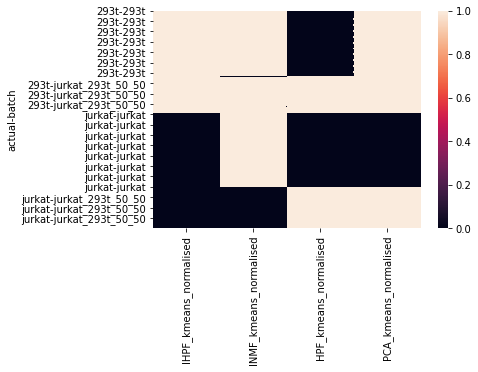

In [48]:
import seaborn as sns
for dataset in ['10Xmouse',]:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    clustered = adata.obs[['actual','batch','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['actual','batch']).sort_index()
    sns.heatmap(clustered)

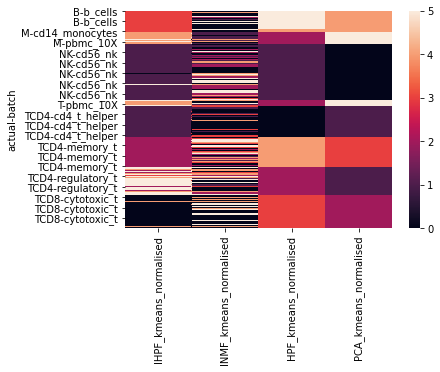

In [49]:
for dataset in ['10Xpbmc',]:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    clustered = adata.obs[['actual','batch','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['actual','batch']).sort_index()
    sns.heatmap(clustered)

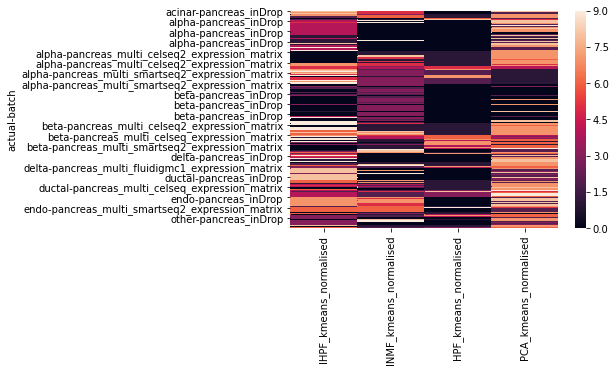

In [50]:
for dataset in ['humanpancreas',]:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    clustered = adata.obs[['actual','batch','IHPF_kmeans_normalised','INMF_kmeans_normalised','HPF_kmeans_normalised','PCA_kmeans_normalised']].set_index(['actual','batch']).sort_index()
    sns.heatmap(clustered)

## TSNE 

In [117]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc',]

In [118]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [119]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    for method in ['IHPF','INMF','HPF','PCA']:
        adata.obsm['{}_TSNE'.format(method)] = TSNE(n_jobs=60).fit_transform(normalize(adata.obsm[method]))
    adata.write('../Data/{}.h5ad'.format(dataset))

## TSNE plot 

In [17]:
import seaborn as sb
import matplotlib.pyplot as plt

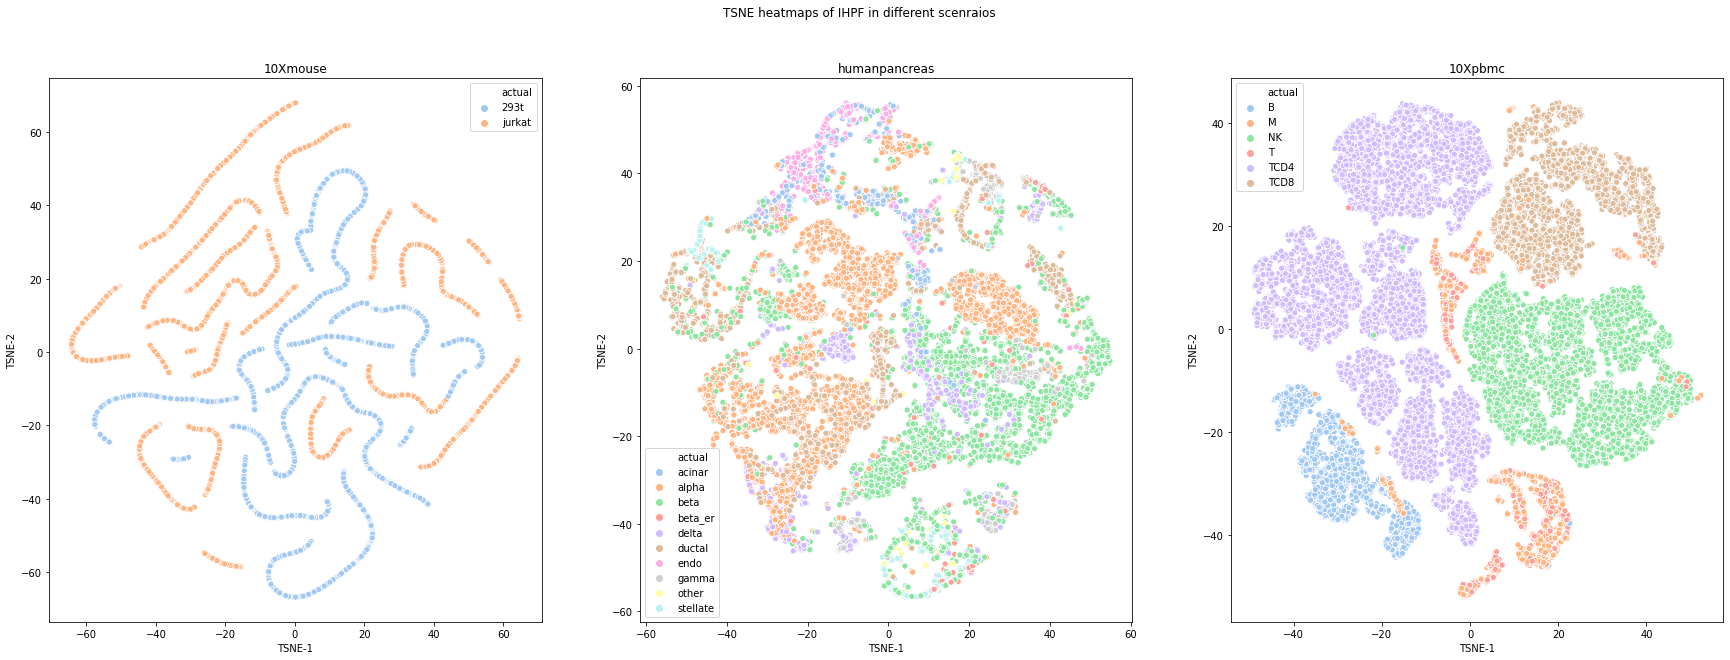

In [19]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of IHPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc']
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'IHPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[cell_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_IHPF_cell_v2.pdf'.format(),format='pdf')

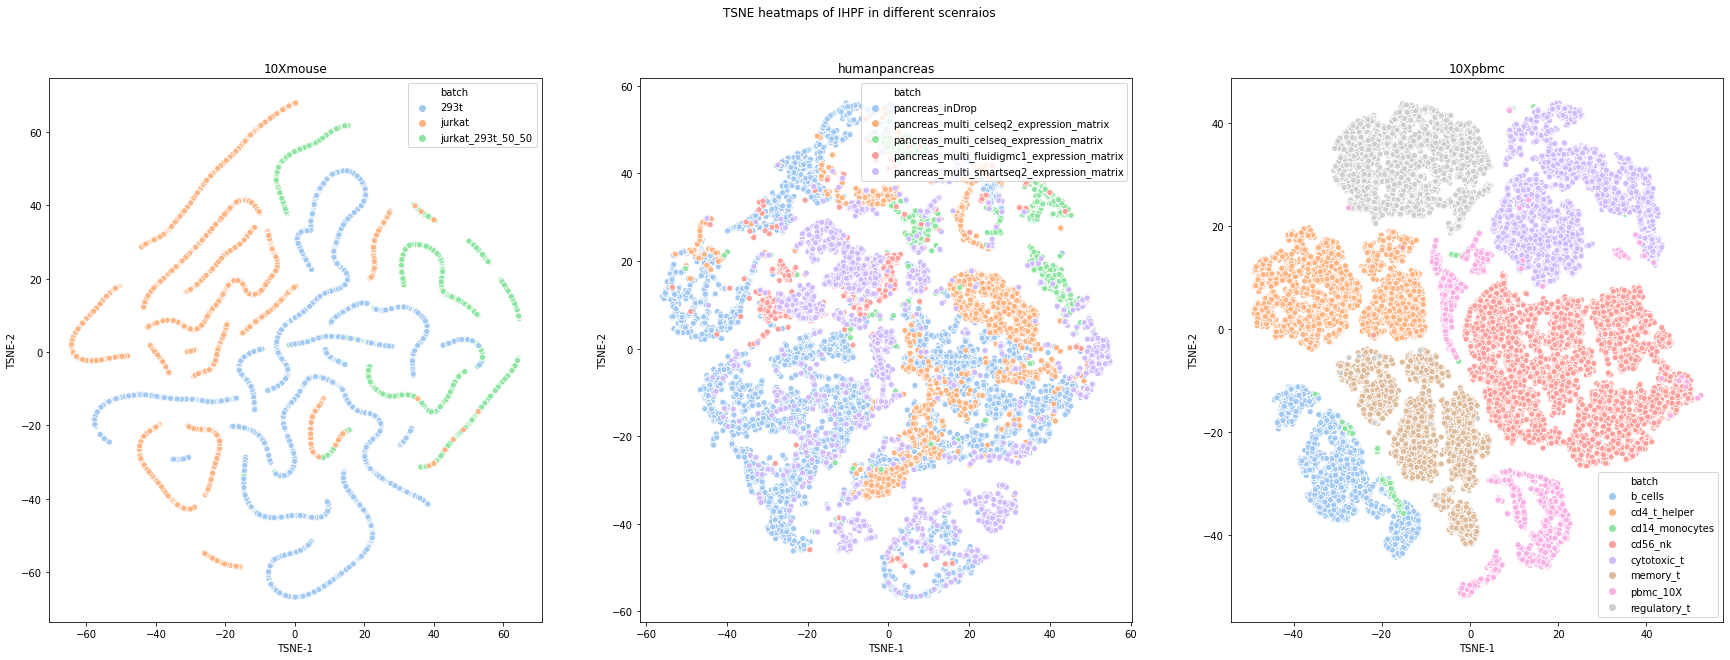

In [20]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of IHPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc',]
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'IHPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[batch_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_IHPF_batch_v2.pdf'.format(),format='pdf')

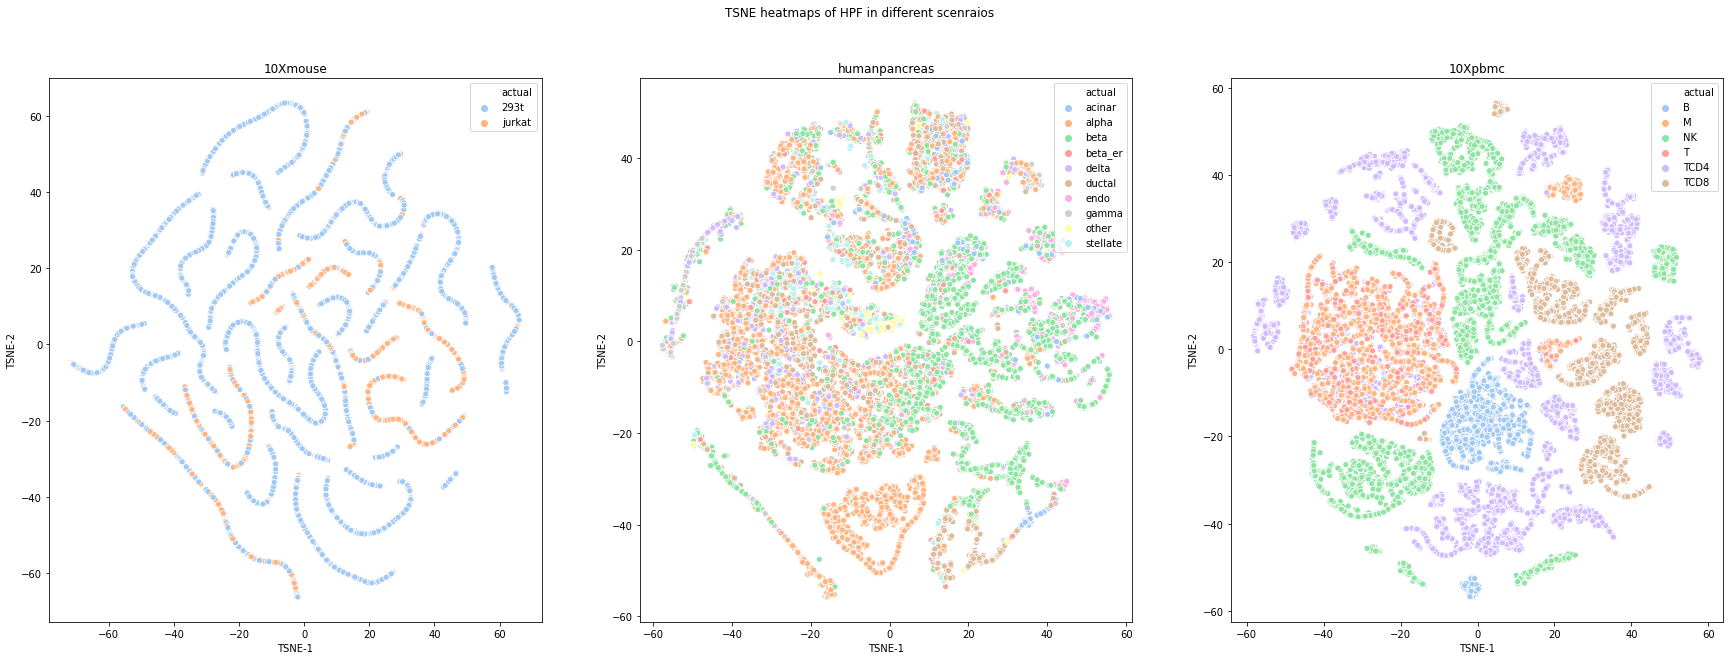

In [21]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of HPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc']
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'HPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[cell_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_HPF_cell_v2.pdf'.format(),format='pdf')

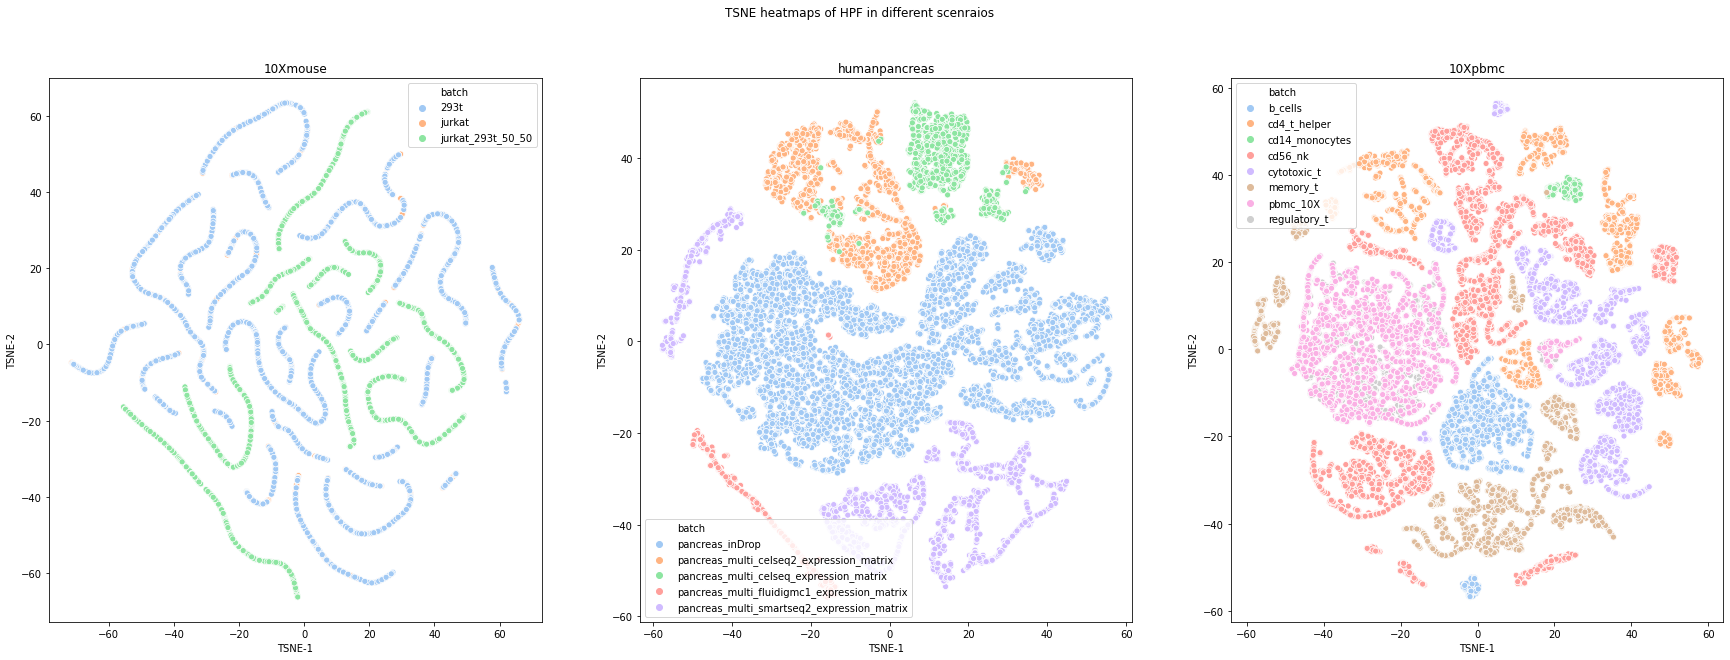

In [22]:
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=False)
f.suptitle('TSNE heatmaps of HPF in different scenraios')

flatui = sb.color_palette("pastel",20)
sb.set_palette(flatui,10)

datasets = ['10Xmouse','humanpancreas','10Xpbmc']
i = 0
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'   
    method = 'HPF'
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    sb.scatterplot(adata.obsm['{}_TSNE'.format(method)][:,0], adata.obsm['{}_TSNE'.format(method)][:,1], hue=adata.obs[batch_labels],legend='full',ax=axes[i])
    axes[i].set(xlabel='TSNE-1', ylabel='TSNE-2',title='{}'.format(dataset))
    i = i + 1
plt.savefig('../Result/TSNE_HPF_batch_v2.pdf'.format(),format='pdf')

## Block structure 

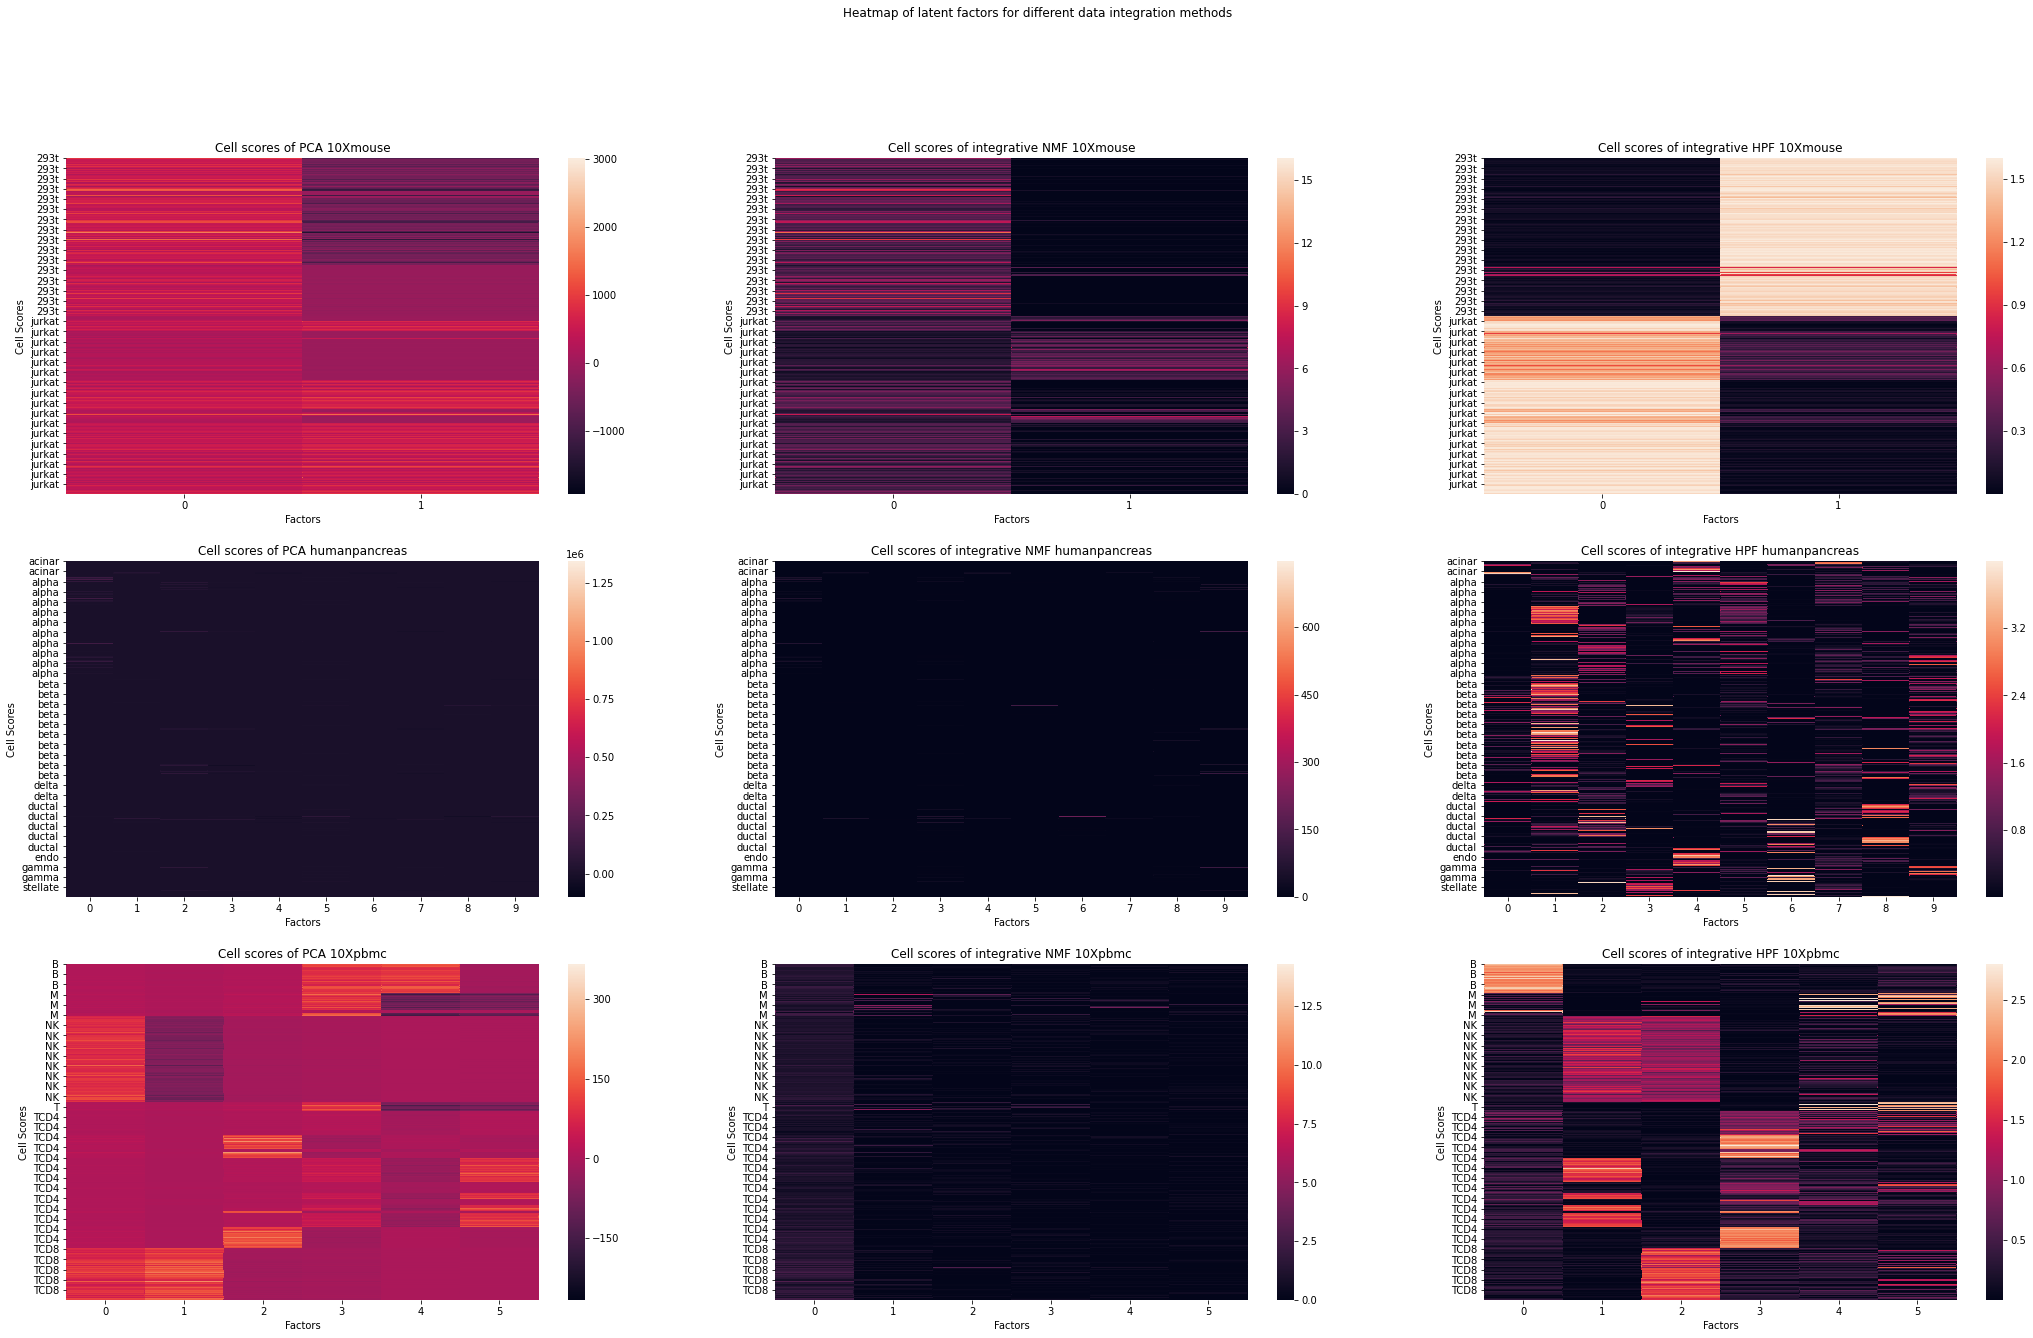

In [24]:
Plot_no = len(datasets)
f, axes = plt.subplots(Plot_no, 3, figsize=(36, 21))
f.suptitle('Heatmap of latent factors for different data integration methods'.format())

j = 0 
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'  
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    # sort the cell score by cell types
    cell_score_df = pd.DataFrame(adata.obsm['PCA'])
    cell_score_df['labels'] = adata.obs[cell_labels].values
    cell_score_df = cell_score_df.set_index(['labels']).sort_index()   
    cell_score_df2 = pd.DataFrame(adata.obsm['INMF'])
    cell_score_df2['labels'] = adata.obs[cell_labels].values
    cell_score_df2 = cell_score_df2.set_index(['labels']).sort_index()
    cell_score_df3 = pd.DataFrame(adata.obsm['IHPF'])
    cell_score_df3['labels'] = adata.obs[cell_labels].values
    cell_score_df3 = cell_score_df3.set_index(['labels']).sort_index()
    
    # Plot heatmap 
    sb.heatmap(cell_score_df, ax=axes[j,0], ).set(xlabel='Factors', ylabel='Cell Scores', title='Cell scores of PCA {}'.format(dataset))
    sb.heatmap(cell_score_df2, ax=axes[j,1],).set(xlabel='Factors', ylabel='Cell Scores', title='Cell scores of integrative NMF {}'.format(dataset))
    sb.heatmap(cell_score_df3, ax=axes[j,2],).set(xlabel='Factors', ylabel='Cell Scores', title='Cell scores of integrative HPF {}'.format(dataset))
    j += 1
    
f.savefig('../Result/Dataset_techs_cellmaps_all_v2.pdf'.format(),format='pdf')

In [25]:
# Gene Scores block structure 

from sklearn.cluster import AgglomerativeClustering, SpectralCoclustering

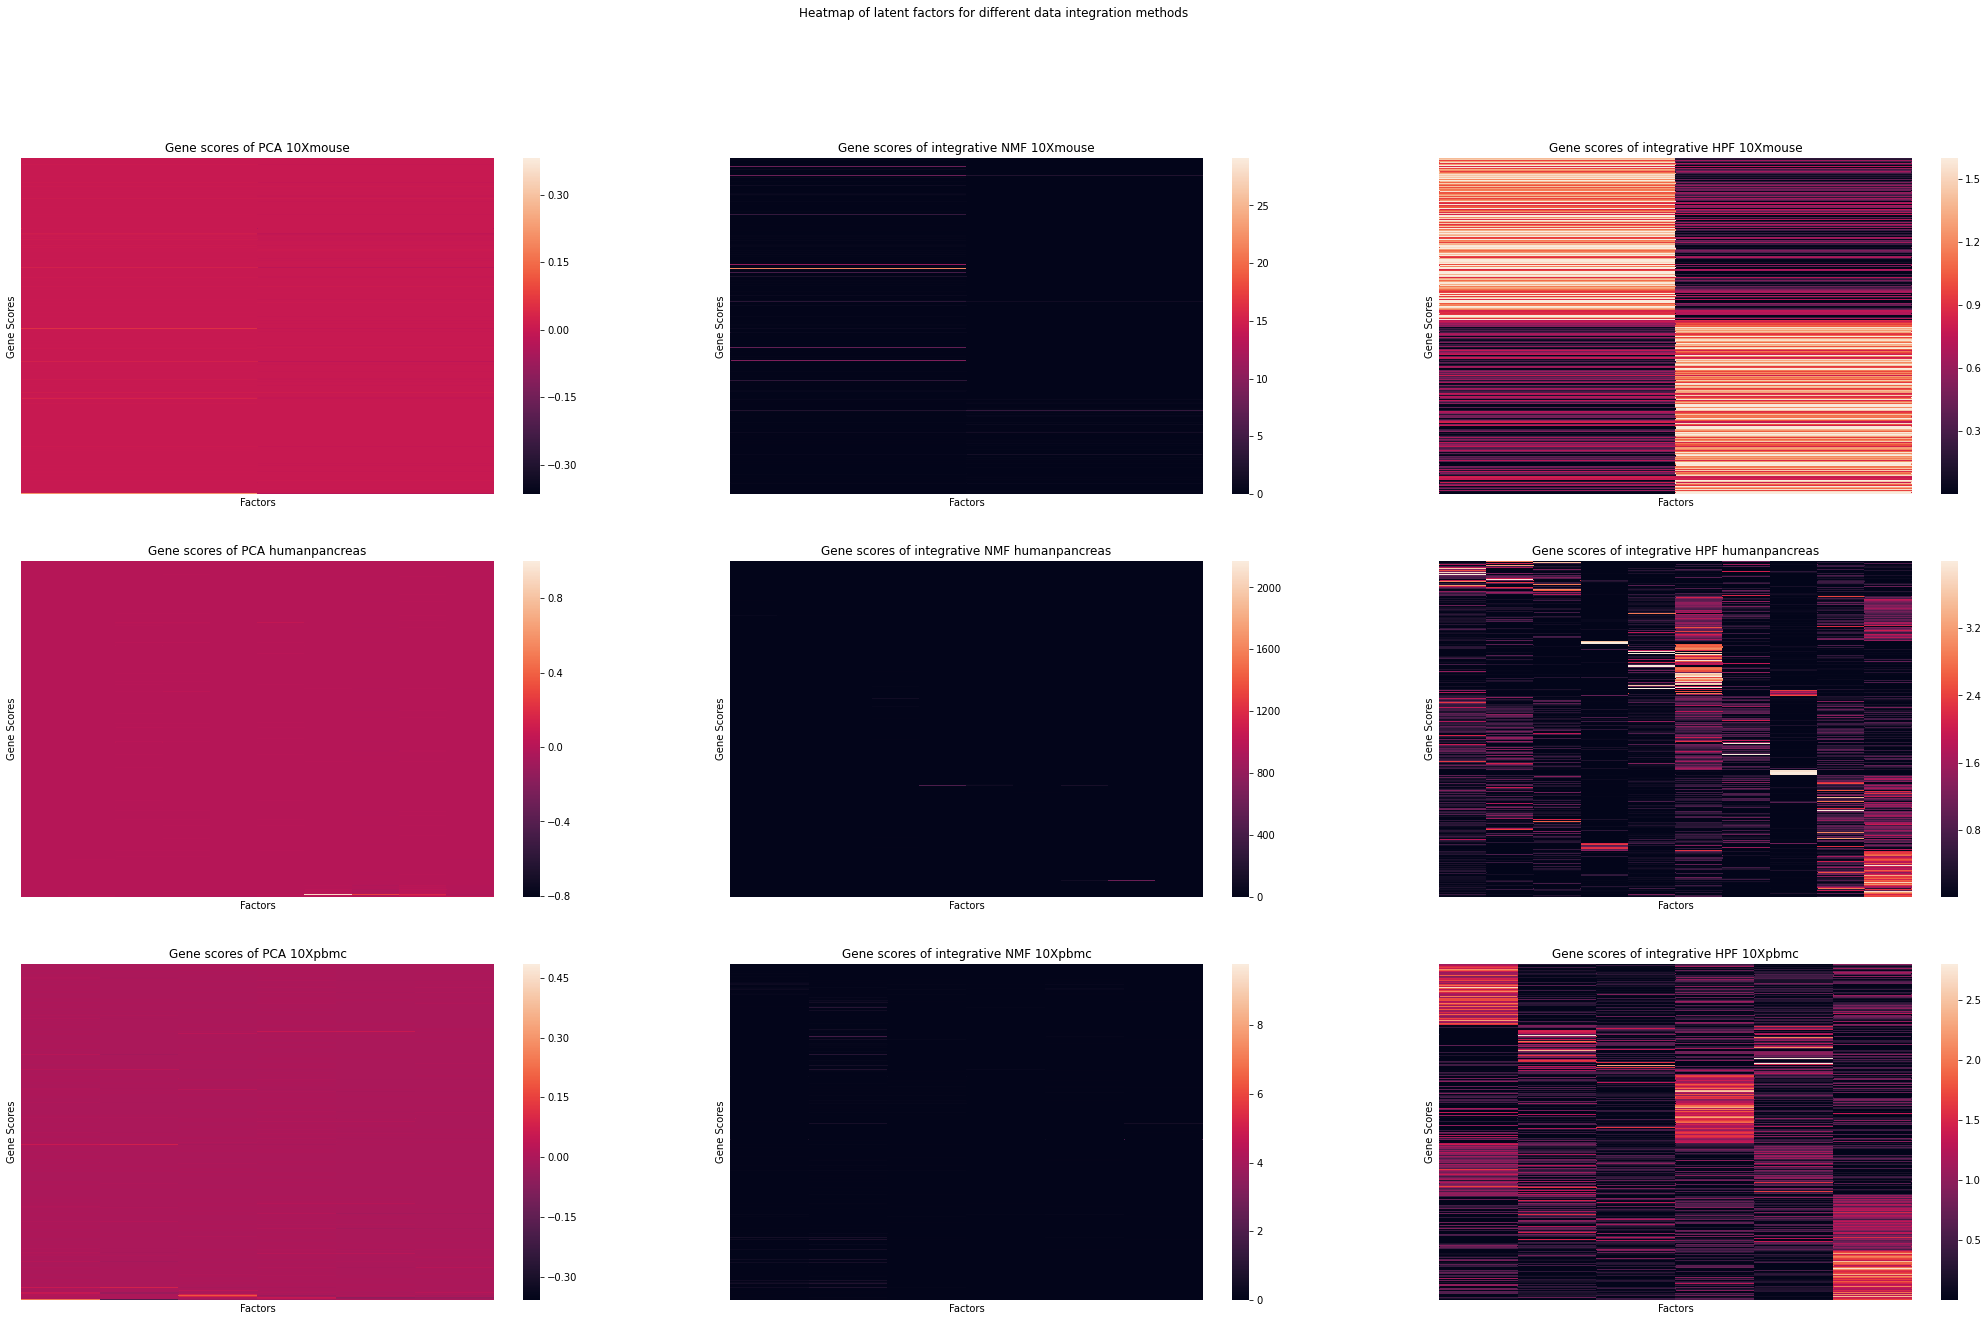

In [26]:
Plot_no = len(datasets)
f, axes = plt.subplots(Plot_no, 3, figsize=(36, 21))
f.suptitle('Heatmap of latent factors for different data integration methods'.format())

j = 0 
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'  
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    # PCA gene scores 
    data= pd.DataFrame(adata.varm['PCA'])
    n_factors = adata.varm['PCA'].shape[1]
    model = SpectralCoclustering(n_clusters=n_factors, random_state=0).fit(data)
    fit_data = data.iloc[np.argsort(model.row_labels_),np.argsort(model.column_labels_)]
    sb.heatmap(fit_data, ax=axes[j, 0], xticklabels=False, yticklabels=False).set(xlabel='Factors', ylabel='Gene Scores', title='Gene scores of PCA {}'.format(dataset))
    # INMF gene scores 
    data= pd.DataFrame(adata.varm['INMF'])
    n_factors = adata.varm['INMF'].shape[1]
    model = SpectralCoclustering(n_clusters=n_factors, random_state=0).fit(data)
    fit_data = data.iloc[np.argsort(model.row_labels_),np.argsort(model.column_labels_)]
    sb.heatmap(fit_data, ax=axes[j, 1], xticklabels=False, yticklabels=False).set(xlabel='Factors', ylabel='Gene Scores', title='Gene scores of integrative NMF {}'.format(dataset))    
    # IHPF gene scores 
    data= pd.DataFrame(adata.varm['IHPF'])
    n_factors = adata.varm['IHPF'].shape[1]
    model = SpectralCoclustering(n_clusters=n_factors, random_state=0).fit(data)
    fit_data = data.iloc[np.argsort(model.row_labels_),np.argsort(model.column_labels_)]
    sb.heatmap(fit_data, ax=axes[j, 2], xticklabels=False, yticklabels=False).set(xlabel='Factors', ylabel='Gene Scores', title='Gene scores of integrative HPF {}'.format(dataset))    
    
    j += 1
    
f.savefig('../Result/Dataset_techs_genemaps_all_v2.pdf'.format(),format='pdf')

## Hyper-parameter search

In [ ]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

In [ ]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'  
    ## Replace this with the location of your h5ad files
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for l in hyper_parameter_space:
        no_cell_types = len(adata.obs[cell_labels].unique())
        no_batches = len(adata.obs[batch_labels].unique())
        # Split cell matrix into batches preserving order 
        Xlist = list()
        split_idx = list()
        for i,df in adata.obs.groupby(batch_labels):
            df_ints = [int(x) for x in df.index]
            split_idx.append(min(df_ints))
        split_idx.append(adata.obs.shape[0])
        split_idx = sorted(split_idx)
        split_starts = split_idx[:-1]
        split_ends = split_idx[1:]
        for i in range(0,no_batches):
            Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
        model = scINMF(no_cell_types,alpha=1/l,max_iter=500)
        model.fit(Xlist)
        adata.obsm['INMF_{}'.format(l)] = np.concatenate(model.cell_scores,axis=0)
        adata.varm['INMF_{}'.format(l)] = model.shared_gene_scores.transpose()
        kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['INMF_{}'.format(l)]))
        adata.obs['INMF_{}_kmeans_normalised'.format(l)] = kmeans_cell.labels_
        adata.obs['INMF_{}_max'.format(l)] = np.argmax(adata.obsm['INMF_{}'.format(l)],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

In [122]:
for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'      
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for l in hyper_parameter_space:
        no_cell_types = len(adata.obs[cell_labels].unique())
        no_batches = len(adata.obs[batch_labels].unique())
        # Split cell matrix into batches preserving order 
        Xlist = list()
        split_idx = list()
        for i,df in adata.obs.groupby(batch_labels):
            df_ints = [int(x) for x in df.index]
            split_idx.append(min(df_ints))
        split_idx.append(adata.obs.shape[0])
        split_idx = sorted(split_idx)
        split_starts = split_idx[:-1]
        split_ends = split_idx[1:]
        for i in range(0,no_batches):
            Xlist.append(coo_matrix(adata.X[split_starts[i]:split_ends[i],:]))
        model = IHPF.scIHPF(no_cell_types,max_iter=500)
        model.fit(Xlist,dataset_ratio=l)
        adata.obsm['IHPF_{}'.format(l)] = np.concatenate(model.cell_scores(),axis=0)
        adata.varm['IHPF_{}'.format(l)] = model.shared_gene_scores()
        kmeans_cell = KMeans(n_clusters=no_cell_types, random_state=0).fit(normalize(adata.obsm['IHPF_{}'.format(l)]))
        adata.obs['IHPF_{}_kmeans_normalised'.format(l)] = kmeans_cell.labels_
        adata.obs['IHPF_{}_max'.format(l)] = np.argmax(adata.obsm['IHPF_{}'.format(l)],axis=1)
    adata.write('../Data/{}.h5ad'.format(dataset))

Clipping dp: was [7.804119377397e-06, 8.257898116426077e-06, 7.050768545013852e-06] now [4.393301496747881e-07, 4.083773528691381e-07, 5.125247407704592e-07]
[Iter.    0]  loss:89.467371  pct:100.000000000
[Iter.   10]  loss:6.579544  pct:-92.645872596
[Iter.   20]  loss:6.506738  pct:-1.106563409
[Iter.   30]  loss:6.415745  pct:-1.398438490
[Iter.   40]  loss:6.380842  pct:-0.544012090
[Iter.   50]  loss:6.366956  pct:-0.217626796
[Iter.   60]  loss:6.341734  pct:-0.396145233
[Iter.   70]  loss:6.315265  pct:-0.417374632
[Iter.   80]  loss:6.302009  pct:-0.209907127
[Iter.   90]  loss:6.295328  pct:-0.106002657
[Iter.  100]  loss:6.291016  pct:-0.068501386
[Iter.  110]  loss:6.287888  pct:-0.049721932
[Iter.  120]  loss:6.285495  pct:-0.038061895
[Iter.  130]  loss:6.283624  pct:-0.029753920
[Iter.  140]  loss:6.282190  pct:-0.022821870
[Iter.  150]  loss:6.281092  pct:-0.017489243
[Iter.  160]  loss:6.280308  pct:-0.012481531
[Iter.  170]  loss:6.279609  pct:-0.011122676
[Iter.  180

[Iter.   60]  loss:7.684331  pct:-0.025463276
[Iter.   70]  loss:7.681273  pct:-0.039798544
[Iter.   80]  loss:7.672952  pct:-0.108320759
[Iter.   90]  loss:7.665887  pct:-0.092082012
[Iter.  100]  loss:7.662588  pct:-0.043036255
[Iter.  110]  loss:7.661603  pct:-0.012855003
[Iter.  120]  loss:7.661168  pct:-0.005672752
[Iter.  130]  loss:7.660711  pct:-0.005968876
[Iter.  140]  loss:7.660556  pct:-0.002021487
[Iter.  150]  loss:7.660373  pct:-0.002392058
[Iter.  160]  loss:7.660178  pct:-0.002542460
[Iter.  170]  loss:7.659739  pct:-0.005728509
[Iter.  180]  loss:7.659477  pct:-0.003424930
[Iter.  190]  loss:7.659253  pct:-0.002917890
[Iter.  200]  loss:7.658978  pct:-0.003590132
[Iter.  210]  loss:7.658680  pct:-0.003890230
[Iter.  220]  loss:7.658498  pct:-0.002374240
[Iter.  230]  loss:7.658300  pct:-0.002584408
[Iter.  240]  loss:7.658099  pct:-0.002634768
[Iter.  250]  loss:7.657894  pct:-0.002675909
[Iter.  260]  loss:7.657719  pct:-0.002282594
[Iter.  270]  loss:7.657536  pct:-

[Iter.   20]  loss:138.995375  pct:-12.560265213
[Iter.   30]  loss:132.079969  pct:-4.975278136
[Iter.   40]  loss:129.315204  pct:-2.093250806
[Iter.   50]  loss:127.993111  pct:-1.022380467
[Iter.   60]  loss:127.283992  pct:-0.554028721
[Iter.   70]  loss:126.847819  pct:-0.342677349
[Iter.   80]  loss:126.575085  pct:-0.215008470
[Iter.   90]  loss:126.389890  pct:-0.146312402
[Iter.  100]  loss:126.253319  pct:-0.108055594
[Iter.  110]  loss:126.156718  pct:-0.076513052
[Iter.  120]  loss:126.084866  pct:-0.056954424
[Iter.  130]  loss:126.028021  pct:-0.045085178
[Iter.  140]  loss:125.982210  pct:-0.036349701
[Iter.  150]  loss:125.942497  pct:-0.031522544
[Iter.  160]  loss:125.905870  pct:-0.029082419
[Iter.  170]  loss:125.873823  pct:-0.025453593
[Iter.  180]  loss:125.845728  pct:-0.022319408
[Iter.  190]  loss:125.822175  pct:-0.018715649
[Iter.  200]  loss:125.802155  pct:-0.015911675
[Iter.  210]  loss:125.784879  pct:-0.013732812
[Iter.  220]  loss:125.769393  pct:-0.0

[Iter.   70]  loss:137.431945  pct:-0.830289814
[Iter.   80]  loss:135.820743  pct:-1.172363154
[Iter.   90]  loss:135.368776  pct:-0.332767468
[Iter.  100]  loss:135.011391  pct:-0.264008606
[Iter.  110]  loss:134.766805  pct:-0.181159123
[Iter.  120]  loss:134.540724  pct:-0.167757389
[Iter.  130]  loss:134.357058  pct:-0.136513673
[Iter.  140]  loss:134.219431  pct:-0.102433500
[Iter.  150]  loss:134.113032  pct:-0.079272310
[Iter.  160]  loss:134.025783  pct:-0.065056130
[Iter.  170]  loss:133.953629  pct:-0.053835991
[Iter.  180]  loss:133.876448  pct:-0.057618121
[Iter.  190]  loss:133.788714  pct:-0.065533147
[Iter.  200]  loss:133.714687  pct:-0.055331606
[Iter.  210]  loss:133.651265  pct:-0.047430508
[Iter.  220]  loss:133.588933  pct:-0.046638051
[Iter.  230]  loss:133.531937  pct:-0.042664873
[Iter.  240]  loss:133.477852  pct:-0.040503641
[Iter.  250]  loss:133.422819  pct:-0.041229908
[Iter.  260]  loss:133.358464  pct:-0.048233834
[Iter.  270]  loss:133.311461  pct:-0.03

[Iter.  120]  loss:129.436174  pct:-0.177342274
[Iter.  130]  loss:129.255978  pct:-0.139216428
[Iter.  140]  loss:129.112789  pct:-0.110779617
[Iter.  150]  loss:128.983213  pct:-0.100358530
[Iter.  160]  loss:128.861555  pct:-0.094320647
[Iter.  170]  loss:128.772341  pct:-0.069232319
[Iter.  180]  loss:128.683181  pct:-0.069238564
[Iter.  190]  loss:128.612574  pct:-0.054868806
[Iter.  200]  loss:128.546774  pct:-0.051161264
[Iter.  210]  loss:128.500981  pct:-0.035623793
[Iter.  220]  loss:128.459775  pct:-0.032066530
[Iter.  230]  loss:128.418156  pct:-0.032398743
[Iter.  240]  loss:128.377844  pct:-0.031391505
[Iter.  250]  loss:128.351300  pct:-0.020675895
[Iter.  260]  loss:128.325224  pct:-0.020316306
[Iter.  270]  loss:128.305071  pct:-0.015704791
[Iter.  280]  loss:128.282853  pct:-0.017316230
[Iter.  290]  loss:128.262410  pct:-0.015935817
[Iter.  300]  loss:128.238656  pct:-0.018520064
[Iter.  310]  loss:128.223595  pct:-0.011744482
[Iter.  320]  loss:128.207931  pct:-0.01

[Iter.  110]  loss:19.863081  pct:-0.058873904
[Iter.  120]  loss:19.853321  pct:-0.049134055
[Iter.  130]  loss:19.845108  pct:-0.041370565
[Iter.  140]  loss:19.838201  pct:-0.034806276
[Iter.  150]  loss:19.831967  pct:-0.031424151
[Iter.  160]  loss:19.826975  pct:-0.025168353
[Iter.  170]  loss:19.822071  pct:-0.024736295
[Iter.  180]  loss:19.817878  pct:-0.021153125
[Iter.  190]  loss:19.813886  pct:-0.020140524
[Iter.  200]  loss:19.810496  pct:-0.017110560
[Iter.  210]  loss:19.806495  pct:-0.020199077
[Iter.  220]  loss:19.802828  pct:-0.018510926
[Iter.  230]  loss:19.799234  pct:-0.018152055
[Iter.  240]  loss:19.795939  pct:-0.016642532
[Iter.  250]  loss:19.792560  pct:-0.017067671
[Iter.  260]  loss:19.789430  pct:-0.015815244
[Iter.  270]  loss:19.786648  pct:-0.014054135
[Iter.  280]  loss:19.784299  pct:-0.011873538
[Iter.  290]  loss:19.781844  pct:-0.012406653
[Iter.  300]  loss:19.779283  pct:-0.012950114
[Iter.  310]  loss:19.777058  pct:-0.011245660
[Iter.  320] 

[Iter.  130]  loss:20.075471  pct:-0.032722576
[Iter.  140]  loss:20.070136  pct:-0.026572332
[Iter.  150]  loss:20.065679  pct:-0.022207368
[Iter.  160]  loss:20.061938  pct:-0.018648318
[Iter.  170]  loss:20.059054  pct:-0.014374458
[Iter.  180]  loss:20.056208  pct:-0.014188435
[Iter.  190]  loss:20.053309  pct:-0.014454532
[Iter.  200]  loss:20.051121  pct:-0.010911430
[Iter.  210]  loss:20.049646  pct:-0.007354978
[Iter.  220]  loss:20.048208  pct:-0.007170549
[Iter.  230]  loss:20.045985  pct:-0.011089037
[Iter.  240]  loss:20.044634  pct:-0.006741468
[Iter.  250]  loss:20.043071  pct:-0.007795253
[Iter.  260]  loss:20.041738  pct:-0.006652336
[Iter.  270]  loss:20.040785  pct:-0.004755900
[Iter.  280]  loss:20.039806  pct:-0.004880158
[Iter.  290]  loss:20.038696  pct:-0.005542416
[Iter.  300]  loss:20.037492  pct:-0.006009770
[Iter.  310]  loss:20.036185  pct:-0.006521060
[Iter.  320]  loss:20.035018  pct:-0.005821710
[Iter.  330]  loss:20.034326  pct:-0.003454074
[Iter.  340] 

[Iter.  170]  loss:5.884648  pct:-0.002625877
[Iter.  180]  loss:5.884590  pct:-0.000983924
[Iter.  190]  loss:5.884516  pct:-0.001248827
[Iter.  200]  loss:5.884435  pct:-0.001380353
[Iter.  210]  loss:5.884341  pct:-0.001604462
[Iter.  220]  loss:5.884276  pct:-0.001102095
[Iter.  230]  loss:5.884230  pct:-0.000775434
[Iter.  240]  loss:5.884184  pct:-0.000793709
converged
Clipping dp: was [0.00010688119800761342, 9.911463712342083e-05, 6.813005165895447e-05, 7.410242687910795e-05] now [7.607926428318023e-05, 7.020594179630279e-05, 5.657629296183586e-05, 7.423592358827591e-05]
[Iter.    0]  loss:6.802734  pct:100.000000000
[Iter.   10]  loss:5.967210  pct:-12.282183424
[Iter.   20]  loss:5.956644  pct:-0.177060239
[Iter.   30]  loss:5.948149  pct:-0.142624163
[Iter.   40]  loss:5.903596  pct:-0.749015668
[Iter.   50]  loss:5.885720  pct:-0.302800848
[Iter.   60]  loss:5.883148  pct:-0.043706976
[Iter.   70]  loss:5.881791  pct:-0.023054990
[Iter.   80]  loss:5.881223  pct:-0.00966093

Clipping dp: was [0.00010688119800761342, 9.911463712342083e-05, 6.813005165895447e-05, 7.410242687910795e-05] now [7.607926428318023e-05, 7.020594179630279e-05, 5.657629296183586e-05, 7.423592358827591e-05]
[Iter.    0]  loss:7.104415  pct:100.000000000
[Iter.   10]  loss:6.110858  pct:-13.985067131
[Iter.   20]  loss:6.039981  pct:-1.159843993
[Iter.   30]  loss:6.014957  pct:-0.414318462
[Iter.   40]  loss:5.964124  pct:-0.845109939
[Iter.   50]  loss:5.933921  pct:-0.506406822
[Iter.   60]  loss:5.927631  pct:-0.105994673
[Iter.   70]  loss:5.923060  pct:-0.077116566
[Iter.   80]  loss:5.918331  pct:-0.079844839
[Iter.   90]  loss:5.916730  pct:-0.027055492
[Iter.  100]  loss:5.914866  pct:-0.031497922
[Iter.  110]  loss:5.914020  pct:-0.014299271
[Iter.  120]  loss:5.913227  pct:-0.013418821
[Iter.  130]  loss:5.912568  pct:-0.011129908
[Iter.  140]  loss:5.912069  pct:-0.008449453
[Iter.  150]  loss:5.911558  pct:-0.008634161
[Iter.  160]  loss:5.911166  pct:-0.006630189
[Iter.  

In [161]:
for dataset in datasets:
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    print(adata)

AnnData object with n_obs × n_vars = 9530 × 13130
    obs: 'actual', 'batch', 'IHPF_kmeans_normalised', 'HPF_kmeans_normalised', 'INMF_kmeans_normalised', 'PCA_kmeans_normalised', 'IHPF_max', 'INMF_max', 'HPF_max', 'PCA_max', 'INMF_0.1_kmeans_normalised', 'INMF_0.1_max', 'INMF_0.5_kmeans_normalised', 'INMF_0.5_max', 'INMF_1.0_kmeans_normalised', 'INMF_1.0_max', 'INMF_10.0_kmeans_normalised', 'INMF_10.0_max', 'INMF_1e-05_kmeans_normalised', 'INMF_1e-05_max', 'INMF_0.0001_kmeans_normalised', 'INMF_0.0001_max', 'INMF_0.001_kmeans_normalised', 'INMF_0.001_max', 'INMF_0.01_kmeans_normalised', 'INMF_0.01_max', 'IHPF_0.1_kmeans_normalised', 'IHPF_0.1_max', 'IHPF_0.5_kmeans_normalised', 'IHPF_0.5_max', 'IHPF_1.0_kmeans_normalised', 'IHPF_1.0_max', 'IHPF_10.0_kmeans_normalised', 'IHPF_10.0_max', 'IHPF_1e-05_kmeans_normalised', 'IHPF_1e-05_max', 'IHPF_0.0001_kmeans_normalised', 'IHPF_0.0001_max', 'IHPF_0.001_kmeans_normalised', 'IHPF_0.001_max', 'IHPF_0.01_kmeans_normalised', 'IHPF_0.01_max'
   

In [28]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

In [29]:
batchAMI = dict()
actualAMI = dict()

for dataset in datasets:
    batch_labels = 'batch'
    cell_labels = 'actual'        
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}.h5ad'.format(dataset))
    a = np.array([0.1, 0.5, 1, 10])
    b = np.array([0.00001, 0.0001, 0.001, 0.01])
    hyper_parameter_space = np.concatenate((a, b), axis=None)
    for method in ['IHPF','INMF']:
        for l in hyper_parameter_space:
            batch[(method,l)] = adjusted_mutual_info_score(adata.obs[batch_labels],adata.obs['{}_{}_kmeans_normalised'.format(method,l)])
            actual[(method,l)] = adjusted_mutual_info_score(adata.obs[cell_labels],adata.obs['{}_{}_kmeans_normalised'.format(method,l)])
    batchAMI[dataset] = batch
    actualAMI[dataset] = actual

In [126]:
np.round(pd.DataFrame(actualAMI),3)

10Xmouse  humanpancreas  10Xpbmc  species
IHPF 0.10000      0.976          0.276    0.590    0.716
     0.50000      0.059          0.317    0.424    0.195
     1.00000      0.023          0.335    0.379    0.743
     10.00000     0.145          0.281    0.081    0.095
     0.00001      0.448          0.293    0.700    0.008
     0.00010     -0.000          0.305    0.875    0.008
     0.00100     -0.000          0.323    0.839    0.031
     0.01000      0.298          0.240    0.732    0.158
INMF 0.10000      0.173          0.208    0.290    0.740
     0.50000      0.176          0.213    0.186    0.772
     1.00000      0.200          0.188    0.043    0.782
     10.00000     0.175          0.204    0.024    0.847
     0.00001      0.173          0.109    0.318    0.725
     0.00010      0.173          0.127    0.318    0.725
     0.00100      0.173          0.137    0.319    0.726
     0.01000      0.173          0.189    0.296    0.727

In [27]:
import seaborn as sb
import matplotlib.pyplot as plt

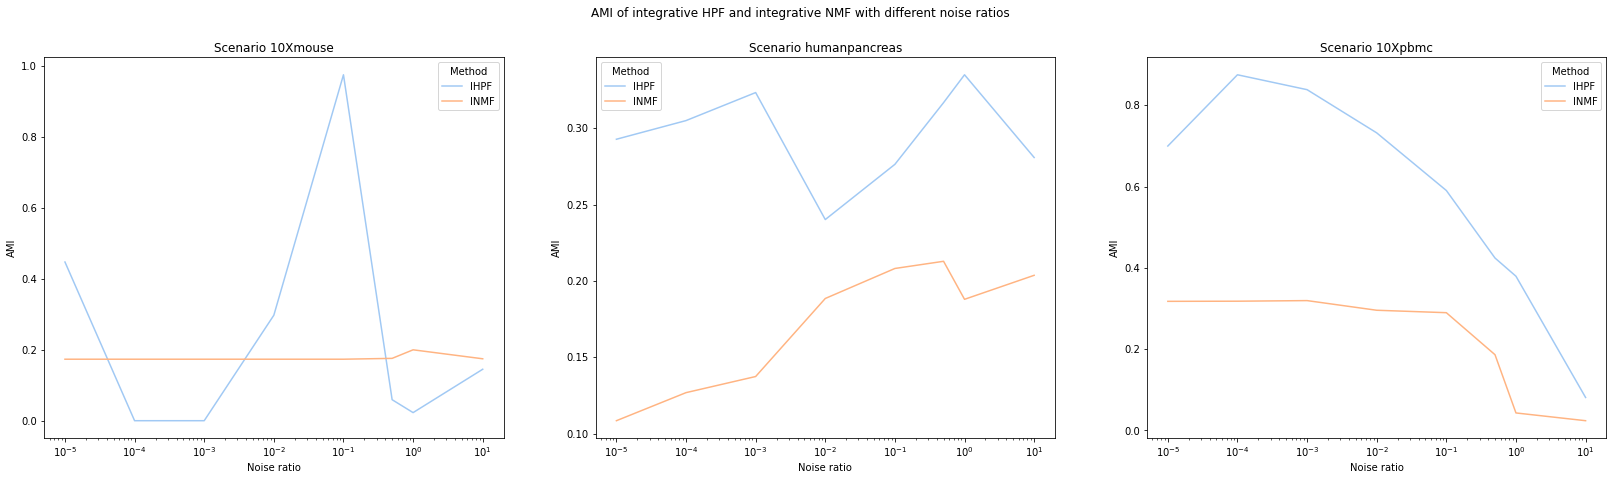

In [31]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(28, 7)
fig.suptitle('AMI of integrative HPF and integrative NMF with different noise ratios')
AMI = pd.DataFrame(actualAMI).reset_index()
AMI.columns = ['Method','Noise'] + datasets
for dataset_no in range(0,3):  
    # reshape multi index df into single index 
    df = AMI.pivot(index="Noise", columns="Method")[datasets[dataset_no]]
    df.plot(ax=axs[dataset_no], logx=True)
    axs[dataset_no].set(xlabel='Noise ratio', ylabel='AMI',title='Scenario {}'.format(datasets[dataset_no]))
plt.savefig('../Result/Grid_Search_AMI_v2.pdf'.format(datasets[dataset_no]),format='pdf')